# **Zero-Shot Object Detection with Grounding DINO**

In this homework, we explore DINO and Grounding DINO, two powerful vision models that give us valuable insights about **self-supervised learning** and **grounding tasks**.

We begin by working with DINO, a self-supervised vision transformer that learns to understand image structure without any labeled data. In this section, you’ll visualize attention maps produced by DINO to see where the model focuses when interpreting an image.

Next, we move on to Grounding DINO, an object detector capable of performing zero-shot detection, detecting and localizing objects based on free-form text prompts like "a person with a hat" or "a red car." This allows you to detect arbitrary objects without any task-specific training.

### What You'll Learn
- How to extract and visualize attention maps from DINO to interpret model focus.
- How to load and use Grounding DINO for zero-shot object detection.
- How to detect objects in images using textual prompts — without any task-specific fine-tuning.
- How to draw bounding boxes and confidence scores on detected objects to visualize the results.
- The strengths and limitations of zero-shot object detection in real-world applications.



We’ll walk through an end-to-end example, starting from setup and preprocessing, all the way to performing detection and visualizing the results.
Let’s dive in and explore how vision and language can come together for powerful object detection, without the need for fine-tuning.

## **Part 1 : Visualizing Attention Maps in DINO**


In this section, we explore **DINO** (Self-Distillation with No Labels), a self-supervised learning framework designed for Vision Transformers (ViTs). Our goal is to understand how DINO works and visualize the attention maps it produces to gain insights into how the model interprets images.

---

### **1. Overview of DINO**

DINO employs a **self-distillation** approach using a student–teacher architecture. Both the student and teacher networks share the same backbone (typically a Vision Transformer), and the learning objective is to produce similar feature representations for different augmented views of the same image (Self-Supervised Learning).

- The **student** network is trained via gradient descent.
- The **teacher** is updated as an **exponential moving average (EMA)** of the student parameters, ensuring stability over time.

This setup encourages the model to learn consistent and robust representations.

---

### **2. Why DINO is Effective**

One of the most intriguing aspects of DINO is that despite being trained without labels, it learns to focus on semantically meaningful regions in an image. This behavior emerges naturally from the **self-attention** mechanism in Vision Transformers, where each patch in the image can attend to all other patches.

By examining the attention weights from the `[CLS]` token to the image patches, we can visualize what parts of the image the model considers important. These attention maps often highlight entire objects or object parts, revealing that DINO captures object-level semantics.

---

### **3. DINO Training Setup**

In the illustration below, the training process is shown for a single pair of augmented views $(x_1, x_2)$ of the same image:

- Both views are passed through the student and teacher networks.
- The teacher’s output is centered using a batch-wise mean to stabilize the learning dynamics.
- Each output is projected into a $K$-dimensional feature space and normalized using a temperature-scaled softmax.
- The similarity between student and teacher outputs is measured using cross-entropy.
- A **stop-gradient** operator is applied to the teacher output to prevent gradient flow through the teacher network.
- The teacher parameters are updated via EMA of the student parameters.

This training pipeline helps the model learn invariant features across different views, and leads to highly structured attention behavior.

---

### **4. Further Reading**

For a further understanding of DINO's methodology, refer to the original paper:  
📄 [DINO: Emerging Properties in Self-Supervised Vision Transformers](https://arxiv.org/abs/2104.14294)

---

In the following cells, we will visualize DINO's attention maps using pretrained weights.


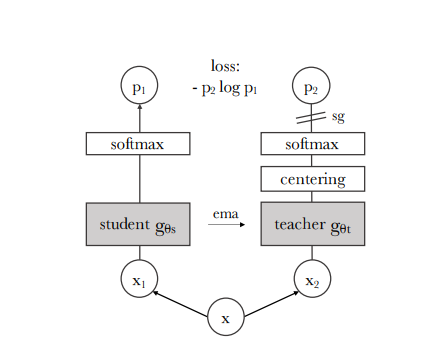

### Load Pretrained DINO

First, we clone the DINO repository from Facebook Research to access the pretrained DINO model. This repository contains the necessary code and model implementations for extracting attention maps.

In [ ]:
!git clone https://github.com/facebookresearch/dino.git

Cloning into 'dino'...
remote: Enumerating objects: 175, done.
remote: Total 175 (delta 0), reused 0 (delta 0), pack-reused 175 (from 1)
Receiving objects: 100% (175/175), 24.47 MiB | 15.34 MiB/s, done.
Resolving deltas: 100% (100/100), done.


We need to navigate to the repository folder to access model files.

In [ ]:
cd dino

/content/dino


### Import Necessary Libraries

Here, we need ton import necessary libraries such as `PIL`, `cv2`, and `skimage` for image processing and `utils` and `vision_trasnformers` for DINO-specific utilities.

In [ ]:
import os
from tqdm import tqdm
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import sys
import argparse
import cv2
import random
import colorsys
import requests
from io import BytesIO
import shutil
import skimage.io
from skimage.measure import find_contours
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms as pth_transforms
import numpy as np
from PIL import Image
import utils
import vision_transformer as vits


### Attention Map Extraction

We define a function `dinoAttention` to extract and visualize attention maps from the DINO model for a given input image. At first, the base model architecture needs to be determined alongside the patch size in which the images are going to be processed. If there's access to the pretrained weights locally, we will need to load them using the weights file. If not, the pretrained weights should be loaded from online resources. Attention maps are normalized, thresholded, and resized to match the original image dimensions.

In [ ]:
def dinoAttention(image_path = None):
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    # Params
    # TODO: Select suitable values for the parameters
    arch = ...
    patch_size = ...

    pretrained_weights = ...
    checkpoint_key = 'student'
    threshold = ...

    # build model
    # TODO: Load and initialize the model using patch_size and arch
    model = ...

    for p in model.parameters():
        p.requires_grad = False

    model.eval()
    model.to(device)


    # TODO: Load the pretrained weights and state dictionary for the model

    # open image
    if image_path is None:
        print("Using default image since no path provided")
        response = requests.get("https://dl.fbaipublicfiles.com/dino/img.png")
        img = Image.open(BytesIO(response.content))
        img = img.convert('RGB')
    elif os.path.isfile(image_path):
        with open(image_path, 'rb') as f:
            img = Image.open(f)
            img = img.convert('RGB')
    else:
        print(f"Provided image path {image_path} is invalid.")
        sys.exit(1)

    # transform image
    transform = pth_transforms.Compose([
        pth_transforms.ToTensor(),
        pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])
    img = transform(img)



    # make the image divisible by the patch size
    w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - img.shape[2] % patch_size
    img = img[:, :w, :h].unsqueeze(0)

    # TODO: Get attention maps
    attentions = ...
    nh = attentions.shape[1]

    # TODO: keep only a certain percentage of the mass


    # TODO: reshape and interpolate attention maps

    # normalize and visualize
    normalized_attentions = np.array([min_max_normalize(attentions[i]) for i in range(attentions.shape[0])])

    # Create visualization
    fig, axes = plt.subplots(1, nh + 1, figsize=(5*(nh + 1), 5))

    # Show original image
    original_img = img.squeeze().permute(1, 2, 0).numpy()
    original_img = (original_img - original_img.min()) / (original_img.max() - original_img.min())
    axes[0].imshow(original_img)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Show each attention head
    for i in range(nh):
        axes[i+1].imshow(normalized_attentions[i], cmap='inferno')
        axes[i+1].set_title(f'Attention Head {i+1}')
        axes[i+1].axis('off')

    plt.tight_layout()
    plt.show()

    return normalized_attentions

def min_max_normalize(x):
    return (x - x.min()) / (x.max() - x.min() + 1e-8)




### Visualization

By calling the `dinoAttention` function with our preferred image as input, we can visualize the attention maps in different attention heads for the image. The original image and attention maps for each head are plotted side by side.
Note that you don't need to implement visualization functions but do so if you feel the need to. 

In [ ]:
attention_maps = dinoAttention("content/cat.JPEG")



**Question :** Based on your observations after showing the attention maps, what information can we gain from each attention map for each head represent?

## **Part 2: Grounding DINO for Text-Guided Object Detection**

In the previous section, we explored how DINO attends to different regions in an image using self- and cross-attention mechanisms. In this section, we examine one of the key applications of DINO: **text-guided object detection**. This task involves detecting and localizing objects in an image based on natural language input, such as "a red backpack" or "a person riding a horse", without being restricted to a predefined set of object categories.

To achieve this, we use **Grounding DINO**, a recent extension of DINO that integrates language understanding into the object detection pipeline. Grounding DINO enables the model to interpret free-form textual descriptions and identify corresponding visual regions, a process known as **grounding**.

---

### **1. What is Grounding?**

In the context of computer vision, *grounding* refers to the task of linking natural language expressions to specific objects or regions within an image. Unlike traditional object detection models, which are typically trained to recognize a fixed list of object categories (e.g., the 80 categories in COCO), grounding models can respond to open-ended textual queries.

**Examples of grounding queries:**
- “Locate the brown dog lying on the grass.”
- “Find the traffic light near the white car.”

Grounding is particularly valuable in applications such as:
- Human-robot interaction  
- Assistive technologies  
- Image retrieval  
- Visual question answering  

By enabling open-vocabulary object detection, grounding allows models to be more flexible and responsive in real-world scenarios.

---

### **2. Grounding DINO Architecture**

Grounding DINO extends the DINO architecture by incorporating a frozen language encoder (such as CLIP or BERT) into the detection framework. This enables the model to process textual descriptions and associate them with visual content.

#### **Key Components:**
- **Visual Backbone (e.g., Swin Transformer):**  
  Extracts multi-scale visual features from the input image.

- **Text Encoder (e.g., CLIP text encoder):**  
  Encodes the input natural language query into a semantic embedding.

- **Transformer Encoder-Decoder:**  
  Aligns visual and textual features using a set of learnable object queries, similar to the standard DINO architecture.

- **Cross-Modal Fusion:**  
  Enhances interaction between visual and textual modalities to improve grounding performance.

- **Prediction Heads:**  
  Produce bounding boxes and corresponding confidence scores based on the aligned features.

This architecture allows Grounding DINO to generalize to unseen object categories and referential expressions at test time, without requiring retraining for each new phrase. The model leverages large-scale pretrained vision-language models to handle open-vocabulary detection tasks effectively.

---

### **4. Further Reading**

For a further understanding of Grounding DINO's architecture, refer to the original paper:  
📄 [Grounding DINO: Marrying DINO with Grounded Pre-Training for Open-Set Object Detection](https://arxiv.org/abs/2303.05499)

---
Proceed to the next cell to begin the implementation.


### Import Necessary Libraries

In [ ]:
import requests
import torch
from PIL import Image, ImageDraw, ImageFont
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
import matplotlib.pyplot as plt
import random

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

### Download Example Data

Here we download rich example images with multiple objects in each, which makes them suitable for zero-shot object detection task.

In [ ]:
%cd {HOME}
!mkdir {HOME}/data
%cd {HOME}/data

!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg

You can use `visualiz_detections` function in order to visualize the detected objects with proper bounding boxes. The color of the bounding box is the same for objects with the same description. The number written above the bounding boxes describes the confidence level of the model about whether the description matches the detected object.

In [ ]:
def visualize_detections(image, boxes, text_labels, scores, font_size=24):
    draw = ImageDraw.Draw(image)

    try:
        font = ImageFont.truetype("arialbd.ttf", font_size)
    except:
        try:
            font = ImageFont.truetype("arial.ttf", font_size)
        except:
            font = ImageFont.load_default()
            if hasattr(font, 'size'):
                font.size = font_size

    color_palette = [
        (255, 99, 132), (54, 162, 235), (255, 206, 86),
        (75, 192, 192), (153, 102, 255), (255, 159, 64),
        (0, 255, 127), (0, 191, 255), (255, 20, 147)
    ]
    color_map = {label: color_palette[i % len(color_palette)] for i, label in enumerate(set(text_labels))}

    for box, label, score in zip(boxes, text_labels, scores):
        color = color_map[label]
        box = box.tolist()

        draw.rectangle(box, outline=color, width=3)

        label_text = f"{label}: {score:.2f}"

        if hasattr(font, 'getbbox'):
            text_bbox = font.getbbox(label_text)
            text_width, text_height = text_bbox[2] - text_bbox[0], text_bbox[3] - text_bbox[1]
        else:
            text_width, text_height = font.getsize(label_text)

        padding_x = 10
        padding_y = 4

        text_bg = [
            box[0] - 2,  # left
            box[1] - text_height - 2*padding_y - 2,  # top
            box[0] + text_width + 2*padding_x,  # right
            box[1]  # bottom
        ]

        draw.rectangle(text_bg, fill=(0, 0, 0))

        text_position = (
            box[0] + padding_x - 2,  # x
            box[1] - text_height - padding_y - 2  # y
        )
        draw.text(text_position, label_text, fill=(255, 255, 255), font=font)

    return image

### Setup and Loading the Model

Load the Grounding DINO model and its corresponding processor here.

In [ ]:
model_id = "IDEA-Research/grounding-dino-tiny"
device = "cuda" if torch.cuda.is_available() else "cpu"

# TODO: Initialize processor and model
processor = ...
model = ...

### Model Inference

Implement the `inference` function here. The purpose of this function is to use Grounding-DINO to detect the objects in the image based on the text prompt and show them if the threshold conditions were met. Pay attention to the fact that you might need to put the prompts variable inside brackets in order for the processor to work properly. This might vary based on implementation.


In [ ]:
def inference(processor, model, prompts, image_path, box_threshold=0.3, text_threshold=0.25):

    image = Image.open(image_path).convert("RGB")
    # TODO: Preprocess the inputs using the processor
    inputs = ...

    # TODO: Generate the outputs
    with torch.no_grad():
      outputs = ...

    # TODO: Using the processor and the generated outputs, generate the results containing boxes, text_labels and confidence scores
    results = ...



    result = results[0]
    # TODO: Initialize boxes, text_labels and scores using the result
    boxes = ...
    text_labels = ...
    scores = ...

    visualized_image = visualize_detections(image.copy(), boxes, text_labels, scores)

    plt.figure(figsize=(16, 18))
    plt.imshow(visualized_image)
    plt.axis('off')
    plt.title("Grounding DINO Detection")
    plt.show()

### Zero-Shot Object Detection

From now on we will test this model on some examples. You are free to use any sort of prompts that satisfy you. Note that setting the correct threshold values plays an important role in how well the model can detect objects and how soft or hard it performs. Try to do trial-and-error with the prompt and the thresholds to understand the performance and limitations of Grounding DINO.

In [ ]:
# TODO: Write suitable text prompts and set suitable values for thresholds
image_name = "dog-3.jpeg"
image_path = os.path.join(HOME, "data", image_name)
prompts = [""]

box_threshold = ...
text_threshold = ...

inference(processor, model, prompts, image_path, box_threshold, text_threshold)

In [ ]:
# TODO: Write suitable text prompts and set suitable values for thresholds
image_name = "dog-3.jpeg"
image_path = os.path.join(HOME, "data", image_name)
prompts = [""]

box_threshold = ...
text_threshold = ...

inference(processor, model, prompts, image_path, box_threshold, text_threshold)

In [ ]:
# TODO: Write suitable text prompts and set suitable values for thresholds
image_name = "dog-2.jpeg"
image_path = os.path.join(HOME, "data", image_name)
prompts = [""]

box_threshold = ...
text_threshold = ...

inference(processor, model, prompts, image_path, box_threshold, text_threshold)

In [ ]:
# TODO: Write suitable text prompts and set suitable values for thresholds
image_name = "dog-2.jpeg"
image_path = os.path.join(HOME, "data", image_name)
prompts = [""]

box_threshold = ...
text_threshold = ...

inference(processor, model, prompts, image_path, box_threshold, text_threshold)